<a href="https://colab.research.google.com/github/teamgaon/lg_farm/blob/main/20220125_hj_EDAipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 사용 패키지

In [1]:
# 그래프 한글 폰트 적용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,278 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and d

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import json
import time
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/LG/train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   creating: train/55844/
  inflating: train/55844/55844.jpg   
  inflating: train/55844/55844.json  
  inflating: train/55844/55844.csv   
   creating: train/55847/
  inflating: train/55847/55847.jpg   
  inflating: train/55847/55847.csv   
  inflating: train/55847/55847.json  
   creating: train/55848/
  inflating: train/55848/55848.json  
  inflating: train/55848/55848.csv   
  inflating: train/55848/55848.jpg   
   creating: train/55858/
  inflating: train/55858/55858.json  
  inflating: train/55858/55858.jpg   
  inflating: train/55858/55858.csv   
   creating: train/55870/
  inflating: train/55870/55870.json  
  inflating: train/55870/55870.csv   
  inflating: train/55870/55870.jpg   
   creating: train/55889/
  inflating: train/55889/55889.jpg   
  inflating: train/55889/55889.csv   
  inflating: train/55889/55889.json  
   creating: train/55895/
  inflating: train/55895/55895.jpg   
  inflating: train/55895/55895.csv   
  inflating: train/558

In [5]:
!unzip /content/drive/MyDrive/LG/test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test/65823/65823.csv    
  inflating: test/65823/65823.jpg    
   creating: test/65824/
  inflating: test/65824/65824.jpg    
  inflating: test/65824/65824.csv    
   creating: test/65825/
  inflating: test/65825/65825.csv    
  inflating: test/65825/65825.jpg    
   creating: test/65827/
  inflating: test/65827/65827.jpg    
  inflating: test/65827/65827.csv    
   creating: test/65828/
  inflating: test/65828/65828.jpg    
  inflating: test/65828/65828.csv    
   creating: test/65829/
  inflating: test/65829/65829.jpg    
  inflating: test/65829/65829.csv    
   creating: test/65830/
  inflating: test/65830/65830.jpg    
  inflating: test/65830/65830.csv    
   creating: test/65831/
  inflating: test/65831/65831.jpg    
  inflating: test/65831/65831.csv    
   creating: test/65832/
  inflating: test/65832/65832.jpg    
  inflating: test/65832/65832.csv    
   creating: test/65833/
  inflating: test/65833/65833.jpg    
  inflating: test

In [6]:
sample = glob('/content/train/*')[42]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

In [7]:
start_time = time.time()
tr_json_list = glob('/content/train/*/*.json')
# tr_json_list = ['./data' + x[1:] for x in tr_json_list]
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.370734930038452 seconds ---


In [8]:
for i, json_file in enumerate(tqdm(tr_json_list)):
    with open(json_file, 'r') as f:
        json_file = json.load(f)
    json_file_re = {
      '주목객체': json_file['annotations']['bbox'],
      '병해부위': json_file['annotations']['part'],
      '촬영부위': json_file['annotations']['area'], 
      '작물': json_file['annotations']['crop'],
      '질병명': json_file['annotations']['disease'],
      '생육단계': json_file['annotations']['grow'],
      '피해정도': json_file['annotations']['risk'],
      '이미지id': json_file['description']['image'],
      '촬영날짜': json_file['description']['date'],
      '촬영시간': json_file['description']['time'],
      'height': json_file['description']['height'],
      'width': json_file['description']['width'],
      '촬영지역': json_file['description']['region'],
      '데이터종류': json_file['description']['task']
      }
    if i == 0:
        tr_json_df = pd.json_normalize(json_file_re)
    else:
        tr_json_df = tr_json_df.append(pd.json_normalize(json_file_re))
tr_json_df = tr_json_df.reset_index(drop=True)

100%|██████████| 5767/5767 [00:42<00:00, 136.31it/s]


In [9]:
# crop
crop_dict = {1 : '딸기',
             2 : '토마토',
             3 : '파프리카',
             4 : '오이', 
             5 : '고추',
             6 : '시설포도'
            }    
# risk
risk_dict = {0 : '정상',
             1 : '초기',
             2 : '중기',
             3 : '말기'}

task_dict = {0 : '정상',
             1 : '병해',
             2 : '생리장해',
            }## 보호제 처리 반응 삭제 tr_json_df['데이터종류'].unique() 3없음
# disease
disease_dict = {'0' : '정상',
                'a1' : '딸기잿빛곰팡이병',
                'a2' : '딸기흰가루병',
                'a3' : '오이노균병',
                'a4' : '오이흰가루병',
                'a5' : '토마토흰가루병',
                'a6' : '토마토잿빛곰팡이병',
                'a7' : '고추탄저병',
                'a8' : '고추흰가루병',
                'a9' : '파프리카흰가루병',
                'a10' : '파프리카잘록병',
                'a11' : '시설포도탄저병',
                'a12' : '시설포도노균병',
                'b1' : '냉해피해',
                'b2' : '열과',
                'b3' : '칼슘결핍',
                'b4' : '일소피해',
                'b5' : '축과병',
                'b6' : '다량원소결핍 (N)',
                'b7' : '다량원소결핍 (P)',
                'b8' : '다량원소결핍 (K)',
                'c1' : '딸기잿빛곰팡이병반응',
                'c2' : '딸기흰가루병반응',
                'c3' : '오이노균병반응',
                'c4' : '오이흰가루병반응',
                'c5' : '토마토흰가루병반응',
                'c6' : '토마토잿빛곰팡이병반응',
                'c7' : '고추탄저병반응',
                'c8' : '고추흰가루병반응',
                'c9' : '파프리카흰가루병반응',
                'c10' : '파프리카잘록병반응',
                'c11' : '시설포도탄저병반응',
                'c12' : '시설포도노균병반응'
               }

area_dict = {1 : '열매',
             2 : '꽃',
             3 : '잎',
             4 : '가지',
             5 : '줄기',
             6 : '뿌리',
             7 : '해충'}

grow_dict = {11: '유모기',
             12: '생장기',
             13: '착화/과실기',
             21: '발아기',
             22: '개화기',
             23: '신초생장기',
             24: '과실성숙기',
             25: '수확기',
             26: '휴먼기'}

In [10]:
tr_json_df['label_code'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)
print("train data에 존재하는 class 수: {len(tr_json_df['label_code'].nunique())}")

tr_json_df['작물'] = tr_json_df['작물'].map(crop_dict) + '(' + tr_json_df['작물'].astype(str) + ')'
tr_json_df['질병명'] = tr_json_df['질병명'].map(disease_dict) + '(' + tr_json_df['질병명'].astype(str) + ')'
tr_json_df['피해정도'] = tr_json_df['피해정도'].map(risk_dict) + '(' + tr_json_df['피해정도'].astype(str) + ')'
tr_json_df['데이터종류'] = tr_json_df['데이터종류'].map(task_dict) + '(' + tr_json_df['데이터종류'].astype(str) + ')'
tr_json_df['촬영부위'] = tr_json_df['촬영부위'].map(area_dict) + '(' + tr_json_df['촬영부위'].astype(str) + ')'
tr_json_df['생육단계'] = tr_json_df['생육단계'].map(grow_dict) + '(' + tr_json_df['생육단계'].astype(str) + ')'

tr_json_df['label_name'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)

train data에 존재하는 class 수: {len(tr_json_df['label_code'].nunique())}


## EDA

### 온도/습도/이슬점이 병의 초기,중기,말기와 어떤 영향이 있는지?

온도 - 초기, 중기, 말기 비슷한 분포를 보임  
습도 - 초기, 중기 비슷한 분포를 보이나 말기는 조금 다름  
이슬점 - 초기, 중기, 말기 흐름은 비슷하나 약간 다름

In [11]:
display(tr_json_df[tr_json_df["피해정도"]=="초기(1)"].head())
display(tr_json_df[tr_json_df["피해정도"]=="중기(2)"].head())
display(tr_json_df[tr_json_df["피해정도"]=="말기(3)"].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
3,"[{'x': 85.00968036954364, 'h': 425.43381076388...","[{'x': 198.38267299107142, 'h': 177.4218594990...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),50753.jpg,20211102,1231,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
5,"[{'x': 20.89108421688988, 'h': 429.11368427579...","[{'x': 85.7133556547619, 'h': 114.427672371031...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),43081.jpg,20211101,1450,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
10,"[{'x': 124.25105406746032, 'h': 437.7624317956...","[{'x': 192.548580109127, 'h': 23.5886966765873...",잎(3),고추(5),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),61914.jpg,20211103,1510,512,384,0,생리장해(2),5_b8_1,고추(5)_다량원소결핍 (K)(b8)_초기(1)
14,"[{'x': 60.17630053323413, 'h': 425.86303323412...","[{'x': 103.37979755704364, 'h': 228.3613436259...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),44206.jpg,20211103,1541,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
15,"[{'x': 128.57156032986111, 'h': 317.4142485119...","[{'x': 137.67937748015873, 'h': 301.6150173611...",잎(3),고추(5),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),41846.jpg,20211102,1613,512,384,0,생리장해(2),5_b6_1,고추(5)_다량원소결핍 (N)(b6)_초기(1)


,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
7,"[{'x': 311.42970367494826, 'h': 477.1484213250...","[{'x': 314.92064570393376, 'h': 150.3492009575...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),34184.jpg,20210809,1728,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
27,"[{'x': 77.1434306795635, 'h': 167.682322668650...","[{'x': 241.07569134424602, 'h': 54.64408172123...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),45590.jpg,20211017,1243,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
29,"[{'x': 173.75944616977225, 'h': 447.0242624223...","[{'x': 287.26717779503105, 'h': 225.6141304347...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),19081.jpg,20210812,1702,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
42,"[{'x': 210.89254712301587, 'h': 148.7268518518...","[{'x': 329.14260912698415, 'h': 48.76291749338...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),54578.jpg,20211017,1258,512,682,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
43,"[{'x': 45.96890888516865, 'h': 282.30791170634...","[{'x': 63.00473167782738, 'h': 21.632796999007...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),중기(2),49938.jpg,20210622,1058,512,242,0,병해(1),3_a9_2,파프리카(3)_파프리카흰가루병(a9)_중기(2)


,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
287,"[{'x': 151.21754849702901, 'h': 421.5164278224...","[{'x': 327.6460809157637, 'h': 147.74803390422...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),44558.jpg,20210807,1740,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
332,"[{'x': 71.8414140625, 'h': 386.524, 'y': 20.06...","[{'x': 72.312671875, 'h': 347.3618125, 'y': 58...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),말기(3),37691.jpg,20210706,0942,512,384,0,병해(1),3_a9_3,파프리카(3)_파프리카흰가루병(a9)_말기(3)
384,"[{'x': 86.85434492807539, 'h': 440.98214285714...","[{'x': 221.92706783234127, 'h': 52.36862909226...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),말기(3),61087.jpg,20210706,0937,512,384,0,병해(1),3_a9_3,파프리카(3)_파프리카흰가루병(a9)_말기(3)
393,"[{'x': 94.72299895141559, 'h': 469.32112897588...","[{'x': 356.32608790632645, 'h': 124.2832051730...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),30889.jpg,20210807,0655,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
512,"[{'x': 87.42857142857143, 'h': 483.85717385912...","[{'x': 217.82857452876985, 'h': 53.48570808531...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),말기(3),42788.jpg,20210622,1055,512,384,0,병해(1),3_a9_3,파프리카(3)_파프리카흰가루병(a9)_말기(3)


In [12]:
display(tr_json_df[tr_json_df["피해정도"]=="초기(1)"].head())
display(tr_json_df[tr_json_df["피해정도"]=="중기(2)"].head())
display(tr_json_df[tr_json_df["피해정도"]=="말기(3)"].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
3,"[{'x': 85.00968036954364, 'h': 425.43381076388...","[{'x': 198.38267299107142, 'h': 177.4218594990...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),50753.jpg,20211102,1231,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
5,"[{'x': 20.89108421688988, 'h': 429.11368427579...","[{'x': 85.7133556547619, 'h': 114.427672371031...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),43081.jpg,20211101,1450,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
10,"[{'x': 124.25105406746032, 'h': 437.7624317956...","[{'x': 192.548580109127, 'h': 23.5886966765873...",잎(3),고추(5),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),61914.jpg,20211103,1510,512,384,0,생리장해(2),5_b8_1,고추(5)_다량원소결핍 (K)(b8)_초기(1)
14,"[{'x': 60.17630053323413, 'h': 425.86303323412...","[{'x': 103.37979755704364, 'h': 228.3613436259...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),44206.jpg,20211103,1541,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
15,"[{'x': 128.57156032986111, 'h': 317.4142485119...","[{'x': 137.67937748015873, 'h': 301.6150173611...",잎(3),고추(5),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),41846.jpg,20211102,1613,512,384,0,생리장해(2),5_b6_1,고추(5)_다량원소결핍 (N)(b6)_초기(1)


,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
7,"[{'x': 311.42970367494826, 'h': 477.1484213250...","[{'x': 314.92064570393376, 'h': 150.3492009575...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),34184.jpg,20210809,1728,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
27,"[{'x': 77.1434306795635, 'h': 167.682322668650...","[{'x': 241.07569134424602, 'h': 54.64408172123...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),45590.jpg,20211017,1243,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
29,"[{'x': 173.75944616977225, 'h': 447.0242624223...","[{'x': 287.26717779503105, 'h': 225.6141304347...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),19081.jpg,20210812,1702,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
42,"[{'x': 210.89254712301587, 'h': 148.7268518518...","[{'x': 329.14260912698415, 'h': 48.76291749338...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),54578.jpg,20211017,1258,512,682,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
43,"[{'x': 45.96890888516865, 'h': 282.30791170634...","[{'x': 63.00473167782738, 'h': 21.632796999007...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),중기(2),49938.jpg,20210622,1058,512,242,0,병해(1),3_a9_2,파프리카(3)_파프리카흰가루병(a9)_중기(2)


,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
287,"[{'x': 151.21754849702901, 'h': 421.5164278224...","[{'x': 327.6460809157637, 'h': 147.74803390422...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),44558.jpg,20210807,1740,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
332,"[{'x': 71.8414140625, 'h': 386.524, 'y': 20.06...","[{'x': 72.312671875, 'h': 347.3618125, 'y': 58...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),말기(3),37691.jpg,20210706,0942,512,384,0,병해(1),3_a9_3,파프리카(3)_파프리카흰가루병(a9)_말기(3)
384,"[{'x': 86.85434492807539, 'h': 440.98214285714...","[{'x': 221.92706783234127, 'h': 52.36862909226...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),말기(3),61087.jpg,20210706,0937,512,384,0,병해(1),3_a9_3,파프리카(3)_파프리카흰가루병(a9)_말기(3)
393,"[{'x': 94.72299895141559, 'h': 469.32112897588...","[{'x': 356.32608790632645, 'h': 124.2832051730...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),30889.jpg,20210807,0655,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
512,"[{'x': 87.42857142857143, 'h': 483.85717385912...","[{'x': 217.82857452876985, 'h': 53.48570808531...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),말기(3),42788.jpg,20210622,1055,512,384,0,병해(1),3_a9_3,파프리카(3)_파프리카흰가루병(a9)_말기(3)


In [13]:
csv_features = [#'내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저',
                #'내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', 
                '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'
                ]

b7 = pd.read_csv('/content/train/63805/63805.csv')[csv_features] #고추
b3 = pd.read_csv('/content/train/18978/18978.csv')[csv_features] #파프리카
b5 =  pd.read_csv('/content/train/18408/18408.csv')[csv_features] #시설포도

a9 =  pd.read_csv('/content/train/31161/31161.csv')[csv_features] #파프리카
a7 =  pd.read_csv('/content/train/53289/53289.csv')[csv_features] #고추
a5 =  pd.read_csv('/content/train/60102/60102.csv')[csv_features] #토마토

a9_1 =  pd.read_csv('/content/train/23323/23323.csv')[csv_features] #파프리카
b4 =  pd.read_csv('/content/train/54869/54869.csv')[csv_features] #시설포도

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/bac

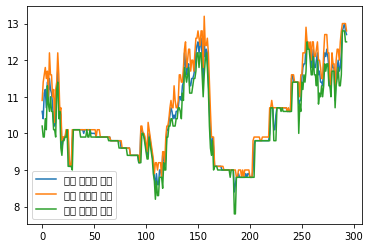

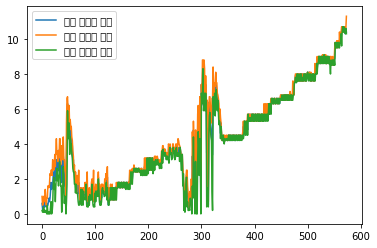

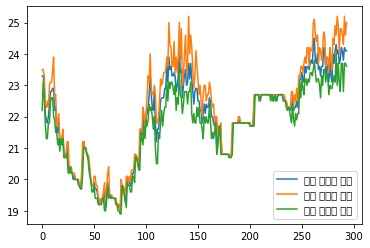

In [14]:
# 초기
b7.plot()
b3.plot()
b5.plot()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_

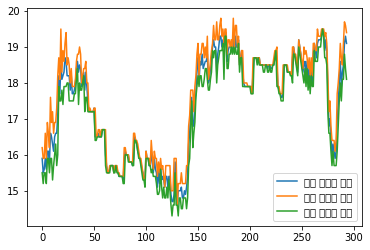

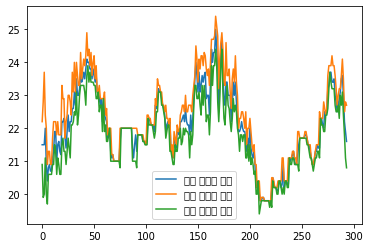

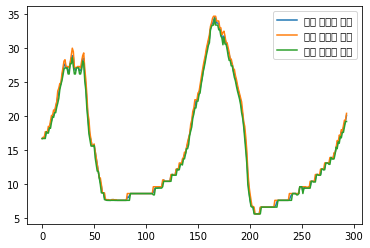

In [15]:
# 중기
a9.plot()
a7.plot()
a5.plot()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_

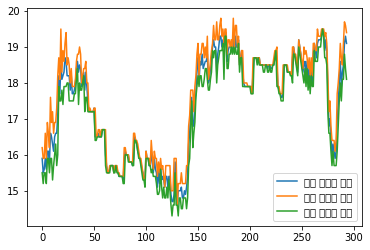

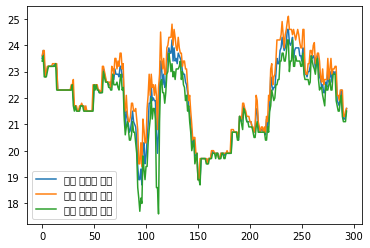

In [16]:
# 말기
a9_1.plot()
b4.plot()

### 일소피해 초기/말기 비교
초기랑 말기랑 다른 분포를 보임

In [17]:
tr_json_df[tr_json_df["질병명"]=="일소피해(b4)"].head()

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
287,"[{'x': 151.21754849702901, 'h': 421.5164278224...","[{'x': 327.6460809157637, 'h': 147.74803390422...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),44558.jpg,20210807,1740,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
393,"[{'x': 94.72299895141559, 'h': 469.32112897588...","[{'x': 356.32608790632645, 'h': 124.2832051730...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),30889.jpg,20210807,0655,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
839,"[{'x': 29.99798099578373, 'h': 339.11604042658...","[{'x': 32.22857181609623, 'h': 106.97143167162...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),40355.jpg,20210825,1457,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
955,"[{'x': 95.59758388675289, 'h': 478.00550506815...","[{'x': 305.91493358965397, 'h': 177.2942808458...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),56570.jpg,20210807,0750,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
1100,"[{'x': 30.803106398809526, 'h': 316.7482018849...","[{'x': 152.14285714285714, 'h': 44.14285714285...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),62040.jpg,20210825,1459,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)


In [18]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고','내부 온도 1 최저'
                #, '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저'
                #,'내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'
                ]

f1 = pd.read_csv('/content/train/12232/12232.csv')[csv_features] #초기
f2 = pd.read_csv('/content/train/51146/51146.csv')[csv_features]
f3 =  pd.read_csv('/content/train/30404/30404.csv')[csv_features]

l1 =  pd.read_csv('/content/train/59933/59933.csv')[csv_features] #말기
l2 =  pd.read_csv('/content/train/50378/50378.csv')[csv_features]
l3 =  pd.read_csv('/content/train/57335/57335.csv')[csv_features]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

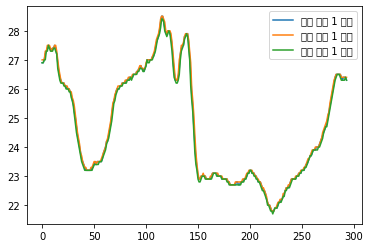

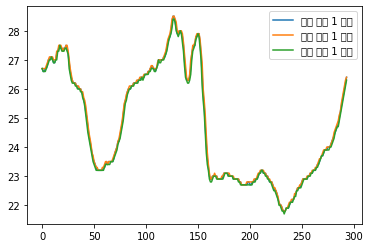

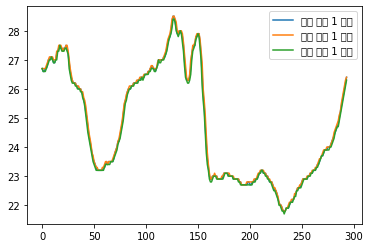

In [19]:
f1.plot()
f2.plot()
f3.plot()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

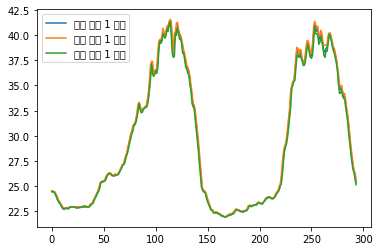

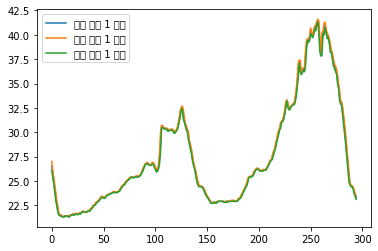

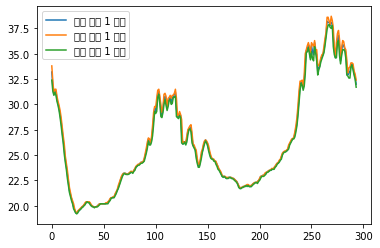

In [20]:
l1.plot()
l2.plot()
l3.plot()

### 파프리카 정상/칼슘결핍
분포 차이 없음.  
csv 불필요

In [21]:
display(tr_json_df[tr_json_df["질병명"]=="칼슘결핍(b3)"].head())
display(tr_json_df[(tr_json_df["작물"]=="파프리카(3)") & (tr_json_df["피해정도"]=="정상(0)")])

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
3,"[{'x': 85.00968036954364, 'h': 425.43381076388...","[{'x': 198.38267299107142, 'h': 177.4218594990...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),50753.jpg,20211102,1231,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
5,"[{'x': 20.89108421688988, 'h': 429.11368427579...","[{'x': 85.7133556547619, 'h': 114.427672371031...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),43081.jpg,20211101,1450,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
129,"[{'x': 145.37117125496033, 'h': 291.0873325892...","[{'x': 220.3136470734127, 'h': 88.393818204365...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),59715.jpg,20211103,1739,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
179,"[{'x': 133.9287574404762, 'h': 316.07496279761...","[{'x': 137.27701822916666, 'h': 117.1888175843...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),58483.jpg,20211103,1737,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
236,"[{'x': 54.40776522197421, 'h': 361.61120411706...","[{'x': 74.05647786458333, 'h': 77.486142113095...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),14093.jpg,20211102,1137,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)


,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
1,"[{'x': 122.5432865203373, 'h': 316.08144221230...",[],잎(3),파프리카(3),NaN,생장기(12),정상(0),45929.jpg,20210923,1343,512,384,0,정상(0),3_00_0,NaN
2,"[{'x': 108.9293929811508, 'h': 316.22972470238...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),47185.jpg,20210915,1551,512,242,0,정상(0),3_00_0,NaN
13,"[{'x': 84.0034921875, 'h': 280.4824375, 'y': 1...",[],잎(3),파프리카(3),NaN,유모기(11),정상(0),31647.jpg,20210915,1604,512,384,0,정상(0),3_00_0,NaN
16,"[{'x': 112.7136015625, 'h': 398.57490625, 'y':...",[],잎(3),파프리카(3),NaN,유모기(11),정상(0),20793.jpg,20210915,1615,512,384,0,정상(0),3_00_0,NaN
17,"[{'x': 185.35787140376985, 'h': 423.7564794146...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),23742.jpg,20210923,1434,512,384,0,정상(0),3_00_0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,"[{'x': 44.797340029761905, 'h': 239.5923549107...",[],잎(3),파프리카(3),NaN,생장기(12),정상(0),64248.jpg,20210924,1203,512,242,0,정상(0),3_00_0,NaN
5733,"[{'x': 190.01195126488096, 'h': 423.5581597222...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),35464.jpg,20210923,1433,512,384,0,정상(0),3_00_0,NaN
5738,"[{'x': 12.050559392051092, 'h': 413.1784784226...",[],잎(3),파프리카(3),NaN,유모기(11),정상(0),62123.jpg,20210917,0928,512,384,0,정상(0),3_00_0,NaN
5740,"[{'x': 179.96709375, 'h': 511.4245, 'y': 0.575...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),38249.jpg,20210915,1630,512,384,0,정상(0),3_00_0,NaN


In [22]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

f_b3_1 = pd.read_csv('/content/train/58687/58687.csv')[csv_features]
f_b3_2 = pd.read_csv('/content/train/40019/40019.csv')[csv_features]
f_b3_3 =  pd.read_csv('/content/train/62587/62587.csv')[csv_features]

n_b3_1 = pd.read_csv('/content/train/21338/21338.csv')[csv_features]
n_b3_2 = pd.read_csv('/content/train/27774/27774.csv')[csv_features]
n_b3_3 =  pd.read_csv('/content/train/25506/25506.csv')[csv_features]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

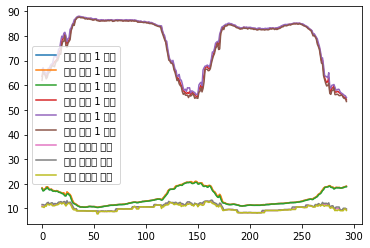

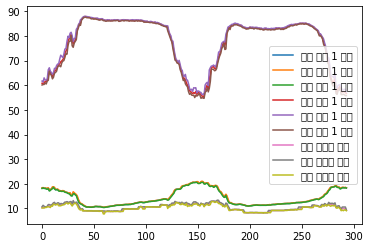

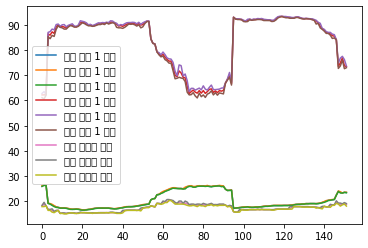

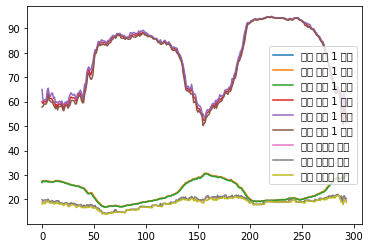

In [23]:
f_b3_2.plot()
f_b3_3.plot()

n_b3_2.plot()
n_b3_3.plot()

### 질병별로 csv가 다른 분포를 보이는가?

파프리카의 질병별 분포 확인  
결론 : 다른 분포를 보인다.

In [24]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']
# 정상 착화/과실기
n3 = pd.read_csv('/content/train/41237/41237.csv')[csv_features]
# 다량원소결핍 (N)(b6) 
b6 = pd.read_csv('/content/train/66064/66064.csv')[csv_features]
# 파프리카흰가루병(a9)
a9 =  pd.read_csv('/content/train/57327/57327.csv')[csv_features]
# 다량원소결핍 (K)(b8)
b8 = pd.read_csv('/content/train/60523/60523.csv')[csv_features]
# 다량원소결핍 (P)(b7)
b7 = pd.read_csv('/content/train/49667/49667.csv')[csv_features]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

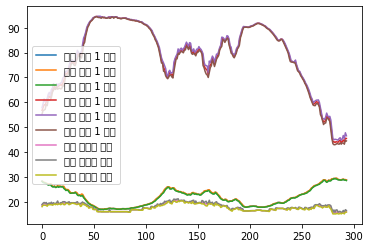

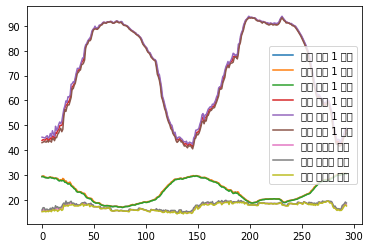

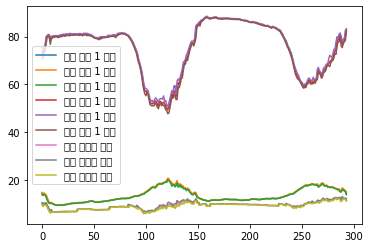

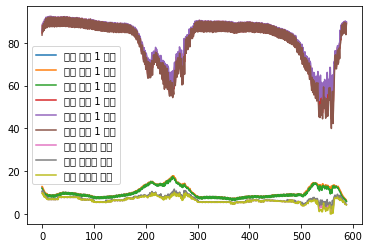

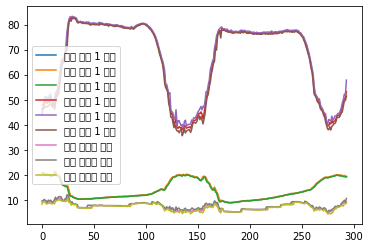

In [25]:
n3.plot()
a9.plot()
b8.plot()
b7.plot()
b6.plot()

### 같은 질병인 것들이 어떤 분포를 보이는가?

1. 흰가루병  
- 식물이 달라도 같은 질병이면 같은 분포를 보인다.

In [26]:
display(tr_json_df[tr_json_df["질병명"].str.contains('흰가루',na=False)].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
27,"[{'x': 77.1434306795635, 'h': 167.682322668650...","[{'x': 241.07569134424602, 'h': 54.64408172123...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),45590.jpg,20211017,1243,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
42,"[{'x': 210.89254712301587, 'h': 148.7268518518...","[{'x': 329.14260912698415, 'h': 48.76291749338...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),54578.jpg,20211017,1258,512,682,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
43,"[{'x': 45.96890888516865, 'h': 282.30791170634...","[{'x': 63.00473167782738, 'h': 21.632796999007...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),중기(2),49938.jpg,20210622,1058,512,242,0,병해(1),3_a9_2,파프리카(3)_파프리카흰가루병(a9)_중기(2)
61,"[{'x': 44.141566685267854, 'h': 432.2570684523...","[{'x': 186.42933097718253, 'h': 48.75074404761...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),중기(2),14975.jpg,20210622,1446,512,384,0,병해(1),3_a9_2,파프리카(3)_파프리카흰가루병(a9)_중기(2)
62,"[{'x': 46.9956484375, 'h': 424.20296875, 'y': ...","[{'x': 49.31704296875, 'h': 170.900640625, 'y'...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),초기(1),52866.jpg,20210706,1009,512,384,0,병해(1),3_a9_1,파프리카(3)_파프리카흰가루병(a9)_초기(1)


In [27]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저',
                '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', 
                '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'
                ]

f1 = pd.read_csv('/content/train/31161/31161.csv')[csv_features] # 파프리카 - 중기
f2 = pd.read_csv('/content/train/60102/60102.csv')[csv_features] # 토마토 - 중기
# 딸기흰가루병,오이 흰가루병,고추 흰가루병은 train data에 존재하지 않음

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

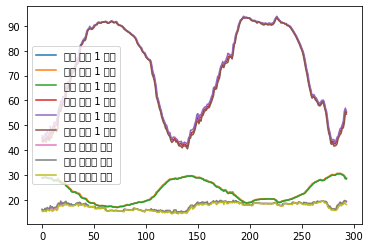

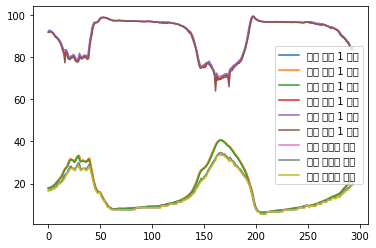

In [28]:
f1.plot()
f2.plot()

2. 탄저병
- 식물이 달라도 같은 질병이면 같은 분포를 보인다.

In [29]:
display(tr_json_df[tr_json_df["질병명"].str.contains('탄저병',na=False)].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
7,"[{'x': 311.42970367494826, 'h': 477.1484213250...","[{'x': 314.92064570393376, 'h': 150.3492009575...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),34184.jpg,20210809,1728,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
29,"[{'x': 173.75944616977225, 'h': 447.0242624223...","[{'x': 287.26717779503105, 'h': 225.6141304347...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),19081.jpg,20210812,1702,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
54,"[{'x': 267.42857142857144, 'h': 452.5714285714...","[{'x': 274.2857142857143, 'h': 174.47619047619...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),41807.jpg,20210810,1706,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
69,"[{'x': 298.4778079710145, 'h': 464.54089026915...","[{'x': 301.28047360248445, 'h': 252.2393892339...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),37735.jpg,20210811,1709,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
80,"[{'x': 276.19122023809524, 'h': 486.6723278985...","[{'x': 317.439990942029, 'h': 90.6971726190476...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),30569.jpg,20210809,1715,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

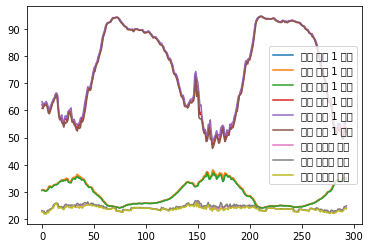

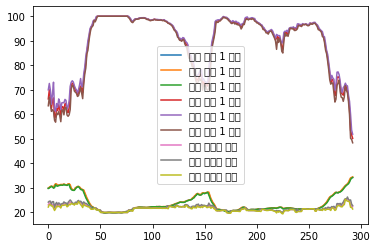

In [30]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

a7 =  pd.read_csv('/content/train/12793/12793.csv')[csv_features] # 고추탄저병(a7) - 중기
a11 = pd.read_csv('/content/train/19548/19548.csv')[csv_features] # 시설포도탄저병(a11) - 중기

a7.plot()
a11.plot()

3. 다량원소결핍(N)

- 식물이 달라도 같은 질병이면 같은 분포를 보인다.

In [31]:
display(tr_json_df[tr_json_df["질병명"].str.contains('N',na=False)].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
14,"[{'x': 60.17630053323413, 'h': 425.86303323412...","[{'x': 103.37979755704364, 'h': 228.3613436259...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),44206.jpg,20211103,1541,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
15,"[{'x': 128.57156032986111, 'h': 317.4142485119...","[{'x': 137.67937748015873, 'h': 301.6150173611...",잎(3),고추(5),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),41846.jpg,20211102,1613,512,384,0,생리장해(2),5_b6_1,고추(5)_다량원소결핍 (N)(b6)_초기(1)
56,"[{'x': 94.28571428571429, 'h': 362.57145957341...","[{'x': 99.85714285714286, 'h': 350.14285714285...",잎(3),고추(5),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),12655.jpg,20211102,1204,512,384,0,생리장해(2),5_b6_1,고추(5)_다량원소결핍 (N)(b6)_초기(1)
63,"[{'x': 106.47309027777777, 'h': 306.0301959325...","[{'x': 108.48204985119048, 'h': 234.3776041666...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),38618.jpg,20211103,1749,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
86,"[{'x': 75.20707775297619, 'h': 352.98421999007...","[{'x': 77.14910404265873, 'h': 346.39949156746...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),65213.jpg,20211029,1307,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

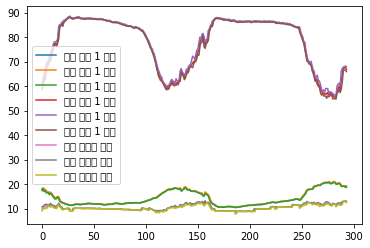

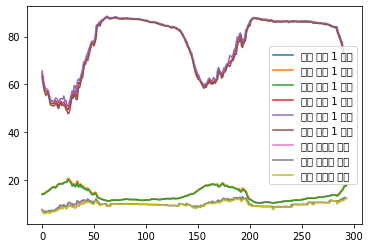

In [32]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

b6_5 =  pd.read_csv('/content/train/40640/40640.csv')[csv_features] # 고추 - 초기
b6_3 = pd.read_csv('/content/train/45375/45375.csv')[csv_features] # 파프리카 - 초기

b6_5.plot()
b6_3.plot()

4. 다량원소결핍(P)

- 식물이 달라도 같은 질병이면 같은 분포를 보인다.

In [36]:
display(tr_json_df[tr_json_df["질병명"].str.contains('P',na=False)].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
23,"[{'x': 62.77840556795635, 'h': 412.67206101190...","[{'x': 189.17491319444446, 'h': 292.9720362103...",잎(3),파프리카(3),다량원소결핍 (P)(b7),착화/과실기(13),초기(1),56139.jpg,20211125,0913,512,384,0,생리장해(2),3_b7_1,파프리카(3)_다량원소결핍 (P)(b7)_초기(1)
24,"[{'x': 130.2872265625, 'h': 227.574046875, 'y'...","[{'x': 130.8342890625, 'h': 86.948578125, 'y':...",잎(3),고추(5),다량원소결핍 (P)(b7),유모기(11),초기(1),38058.jpg,20211202,1414,512,384,0,생리장해(2),5_b7_1,고추(5)_다량원소결핍 (P)(b7)_초기(1)
30,"[{'x': 113.48543681795636, 'h': 415.8871527777...","[{'x': 115.27774677579364, 'h': 413.3318142361...",잎(3),파프리카(3),다량원소결핍 (P)(b7),착화/과실기(13),초기(1),27315.jpg,20211125,0857,512,384,0,생리장해(2),3_b7_1,파프리카(3)_다량원소결핍 (P)(b7)_초기(1)
58,"[{'x': 60.1709953187004, 'h': 412.794642857142...","[{'x': 60.81800672743056, 'h': 412.79464285714...",잎(3),파프리카(3),다량원소결핍 (P)(b7),착화/과실기(13),초기(1),57419.jpg,20211125,0909,512,384,0,생리장해(2),3_b7_1,파프리카(3)_다량원소결핍 (P)(b7)_초기(1)
71,"[{'x': 146.57142857142858, 'h': 219.4285714285...","[{'x': 146.57142857142858, 'h': 171.8571428571...",잎(3),파프리카(3),다량원소결핍 (P)(b7),착화/과실기(13),초기(1),19906.jpg,20211125,0859,512,384,0,생리장해(2),3_b7_1,파프리카(3)_다량원소결핍 (P)(b7)_초기(1)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

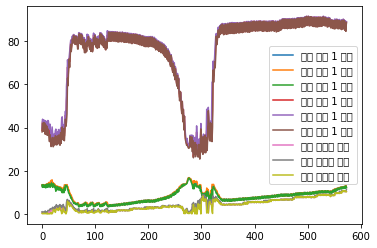

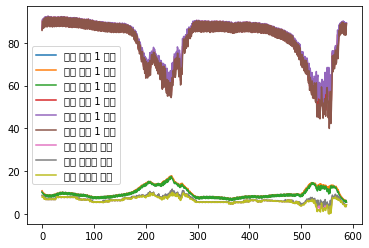

In [37]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

b7_5 =  pd.read_csv('/content/train/38058/38058.csv')[csv_features] # 고추 - 초기
b7_3 = pd.read_csv('/content/train/56139/56139.csv')[csv_features] # 파프리카 - 초기

b7_5.plot()
b7_3.plot()

5. 다량원소결핍(K)

- 식물이 달라도 같은 질병이면 같은 분포를 보인다.

In [38]:
display(tr_json_df[tr_json_df["질병명"].str.contains('K',na=False)].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
10,"[{'x': 124.25105406746032, 'h': 437.7624317956...","[{'x': 192.548580109127, 'h': 23.5886966765873...",잎(3),고추(5),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),61914.jpg,20211103,1510,512,384,0,생리장해(2),5_b8_1,고추(5)_다량원소결핍 (K)(b8)_초기(1)
50,"[{'x': 110.05685763888889, 'h': 368.9850260416...","[{'x': 240.343021453373, 'h': 51.7715928819444...",잎(3),파프리카(3),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),11242.jpg,20211102,1606,512,384,0,생리장해(2),3_b8_1,파프리카(3)_다량원소결핍 (K)(b8)_초기(1)
52,"[{'x': 103.95379154265873, 'h': 458.8825644841...","[{'x': 108.6166759672619, 'h': 450.37965029761...",잎(3),고추(5),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),61517.jpg,20211109,1212,512,384,0,생리장해(2),5_b8_1,고추(5)_다량원소결핍 (K)(b8)_초기(1)
64,"[{'x': 83.70387679811508, 'h': 473.78245907738...","[{'x': 90.40045262896825, 'h': 462.90054563492...",잎(3),고추(5),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),55662.jpg,20211102,1605,512,384,0,생리장해(2),5_b8_1,고추(5)_다량원소결핍 (K)(b8)_초기(1)
82,"[{'x': 62.94632781498016, 'h': 419.87593005952...","[{'x': 195.2381107390873, 'h': 33.333337208581...",잎(3),파프리카(3),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),45962.jpg,20211103,1527,512,384,0,생리장해(2),3_b8_1,파프리카(3)_다량원소결핍 (K)(b8)_초기(1)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

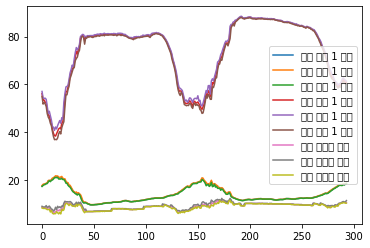

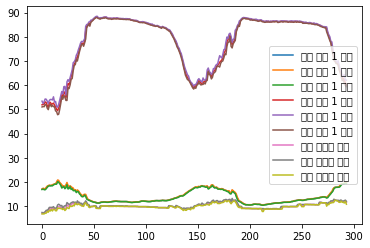

In [39]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

b8_5 =  pd.read_csv('/content/train/61914/61914.csv')[csv_features] # 고추 - 초기
b8_3 = pd.read_csv('/content/train/11242/11242.csv')[csv_features] # 파프리카 - 초기

b8_5.plot()
b8_3.plot()